# XID+MIPS_SPIRE_SED_Analysis_32
This notebook takes the posterior of the XID+MIPS_SPIRE_SED run and examines outputs with some useful visualisation.

In [1]:
from astropy.io import ascii, fits
import pylab as plt
%matplotlib inline
from astropy import wcs


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import pandas as pd
import seaborn as sns

In [2]:
# load up run
priors,posterior=xidplus.load(filename='./XID+MIPS_SPIRE_SED_ESB_32_added_source_750iter_flag_gaia_wdiv.pkl')



In [3]:
from astropy.table import Table, hstack

scat250=Table.read('../WP5-Lockman-SWIRE-SCAT250-v1.0.fits.gz')
scat350=Table.read('../WP5-Lockman-SWIRE-SCAT350-v1.0.fits.gz')
scat500=Table.read('../WP5-Lockman-SWIRE-SCAT500-v1.0.fits.gz')


## Plot maps
1. The actual maps.
2. The posterior sample maps as a movie. Each frame is a replicated map from our model. Its shows the range of maps our model would allow, having been constrained on the data.
3. The Bayesian P value map

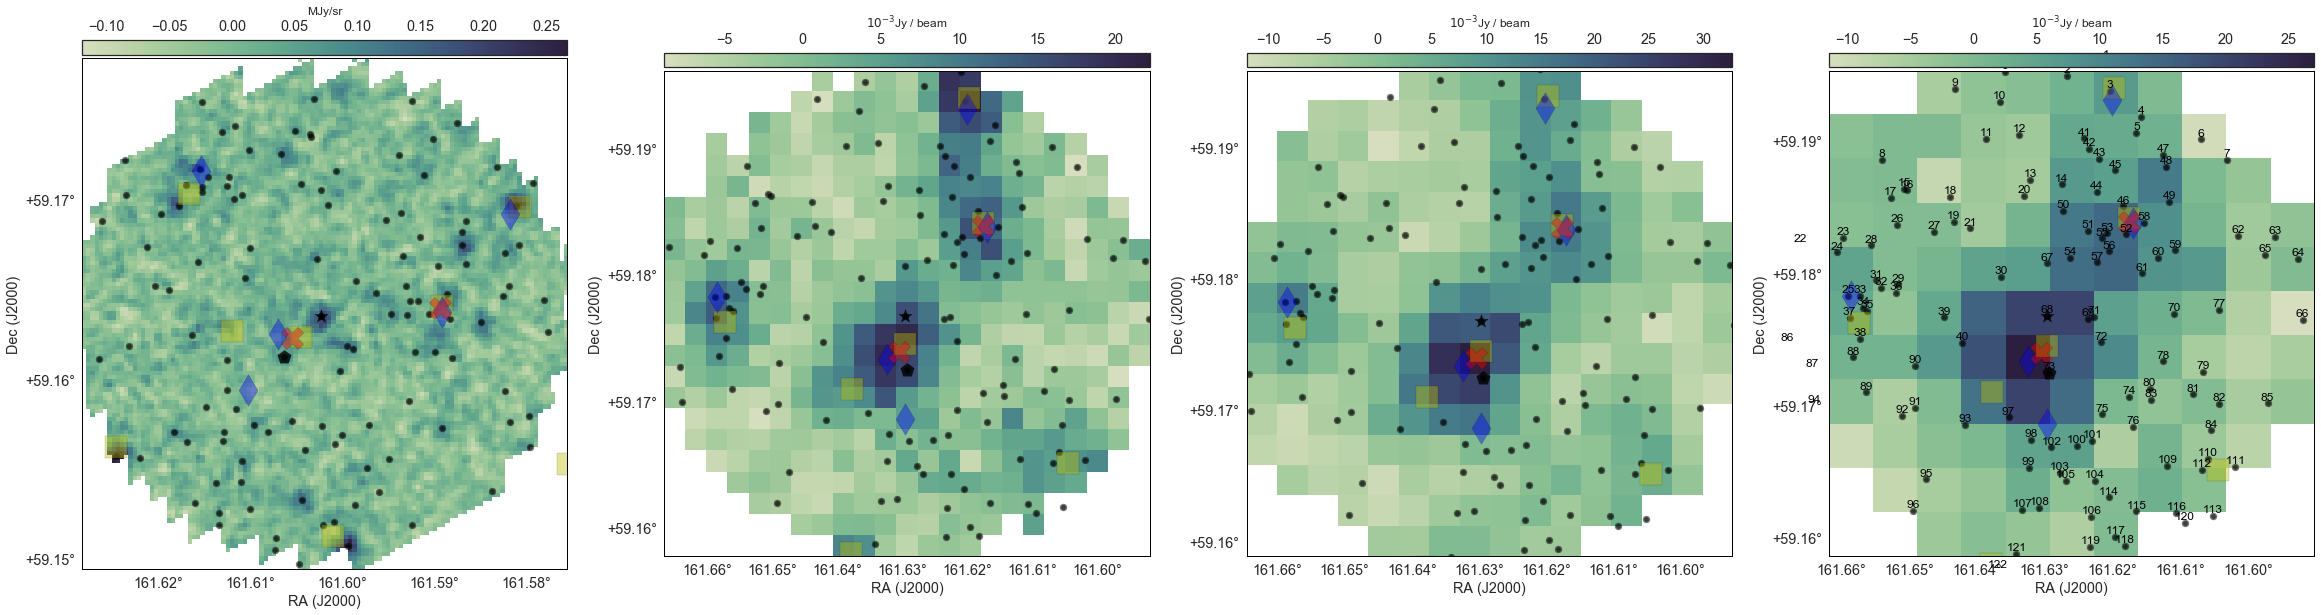

In [4]:
from xidplus import plots
orig_map=plots.plot_map(priors);

for i in range(0,priors[0].nsrc):#[ 2, 35, 51, 86, 90]:
    orig_map[0][3].add_label(priors[0].sra[i], priors[0].sdec[i]+0.0005, np.arange(0,priors[0].nsrc)[i], relative=False)

orig_map[0][0].colorbar.set_axis_label_text(priors[0].imhdu['BUNIT'])
orig_map[0][1].colorbar.set_axis_label_text('$10^{-3}$'+priors[1].imhdu['BUNIT'])
orig_map[0][2].colorbar.set_axis_label_text('$10^{-3}$'+priors[2].imhdu['BUNIT'])
orig_map[0][3].colorbar.set_axis_label_text('$10^{-3}$'+priors[3].imhdu['BUNIT'])


for i in range(0,4):
    orig_map[0][i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=50, alpha=0.5)
    orig_map[0][i].show_markers(priors[0].sra[68], priors[0].sdec[68], edgecolor='black', facecolor='black',
                marker='*', s=200, alpha=0.8)
    orig_map[0][i].show_markers(priors[0].sra[73], priors[0].sdec[73], edgecolor='black', facecolor='black',
                marker='p', s=200, alpha=0.8)
    orig_map[0][i].set_tick_labels_font(size='large')
    orig_map[0][i].axis_labels.set_font(size='large')
    orig_map[0][i].colorbar.set_font(size='large')
    
    orig_map[0][i].show_markers(scat250['RA'],scat250['Dec'], edgecolor='k', facecolor='y',
                                marker='s', s=500, alpha=0.4)
    orig_map[0][i].show_markers(scat350['RA'],scat350['Dec'], edgecolor='k', facecolor='b',
                                marker='d', s=500, alpha=0.4)
    orig_map[0][i].show_markers(scat500['RA'],scat500['Dec'], edgecolor='k', facecolor='r',
                                marker='X', s=500, alpha=0.4)

A plot of our sources (in black) on the 4 maps is shown above. The 250, 350 and 500 $\mathrm{\mu m}$ HerMES SCAT catalogues are plotted as yellow squares, blue diamonds and red crosses respectively. Two masterlist sources could be possibly contributing to the SPIRE SCAT sources, our `HELP_J104631.170+591036.829` source (for which Rowan-Robinson et al. 2017 attributes all the SPIRE flux to) and `HELP_J104631.082+591021.253`. We plot these sources with a black star and black pentagon respectively. In total, our first model consists of 123 sources.

In [5]:
movie=plots.replicated_map_movie(priors,posterior, 20)

In [6]:
movie

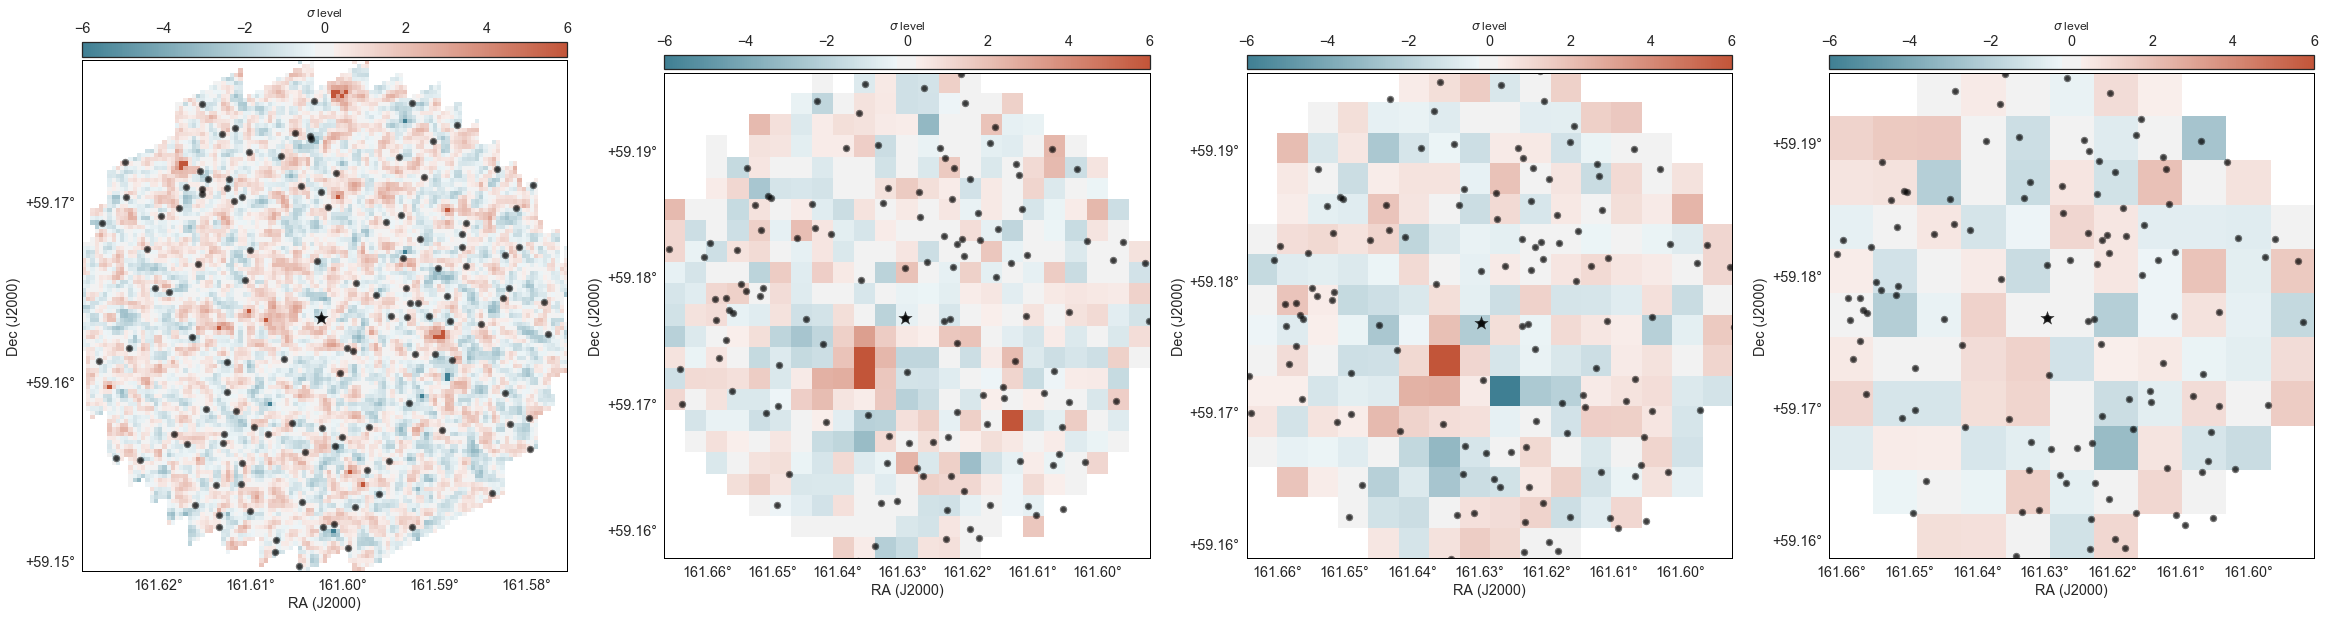

In [7]:
bayes_map=plots.plot_Bayes_pval_map(priors, posterior)

for i in range(0,4):
    bayes_map[0][i].colorbar.set_axis_label_text('$\sigma$ level')
    bayes_map[0][i].set_tick_labels_font(size='large')
    bayes_map[0][i].axis_labels.set_font(size='large')
    bayes_map[0][i].colorbar.set_font(size='large')
    bayes_map[0][i].show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=50, alpha=0.5)
    bayes_map[0][i].show_markers(priors[0].sra[[68]], priors[0].sdec[[68]], edgecolor='black', facecolor='black',
                marker='*', s=200, alpha=0.8)

## 2D marginalised plot for fluxes

### Choose which source we want to look at


In [8]:
s1=68
priors[0].ID[s1]

'HELP_J104631.170+591036.829'

## Let's look at the marginalised colour plots

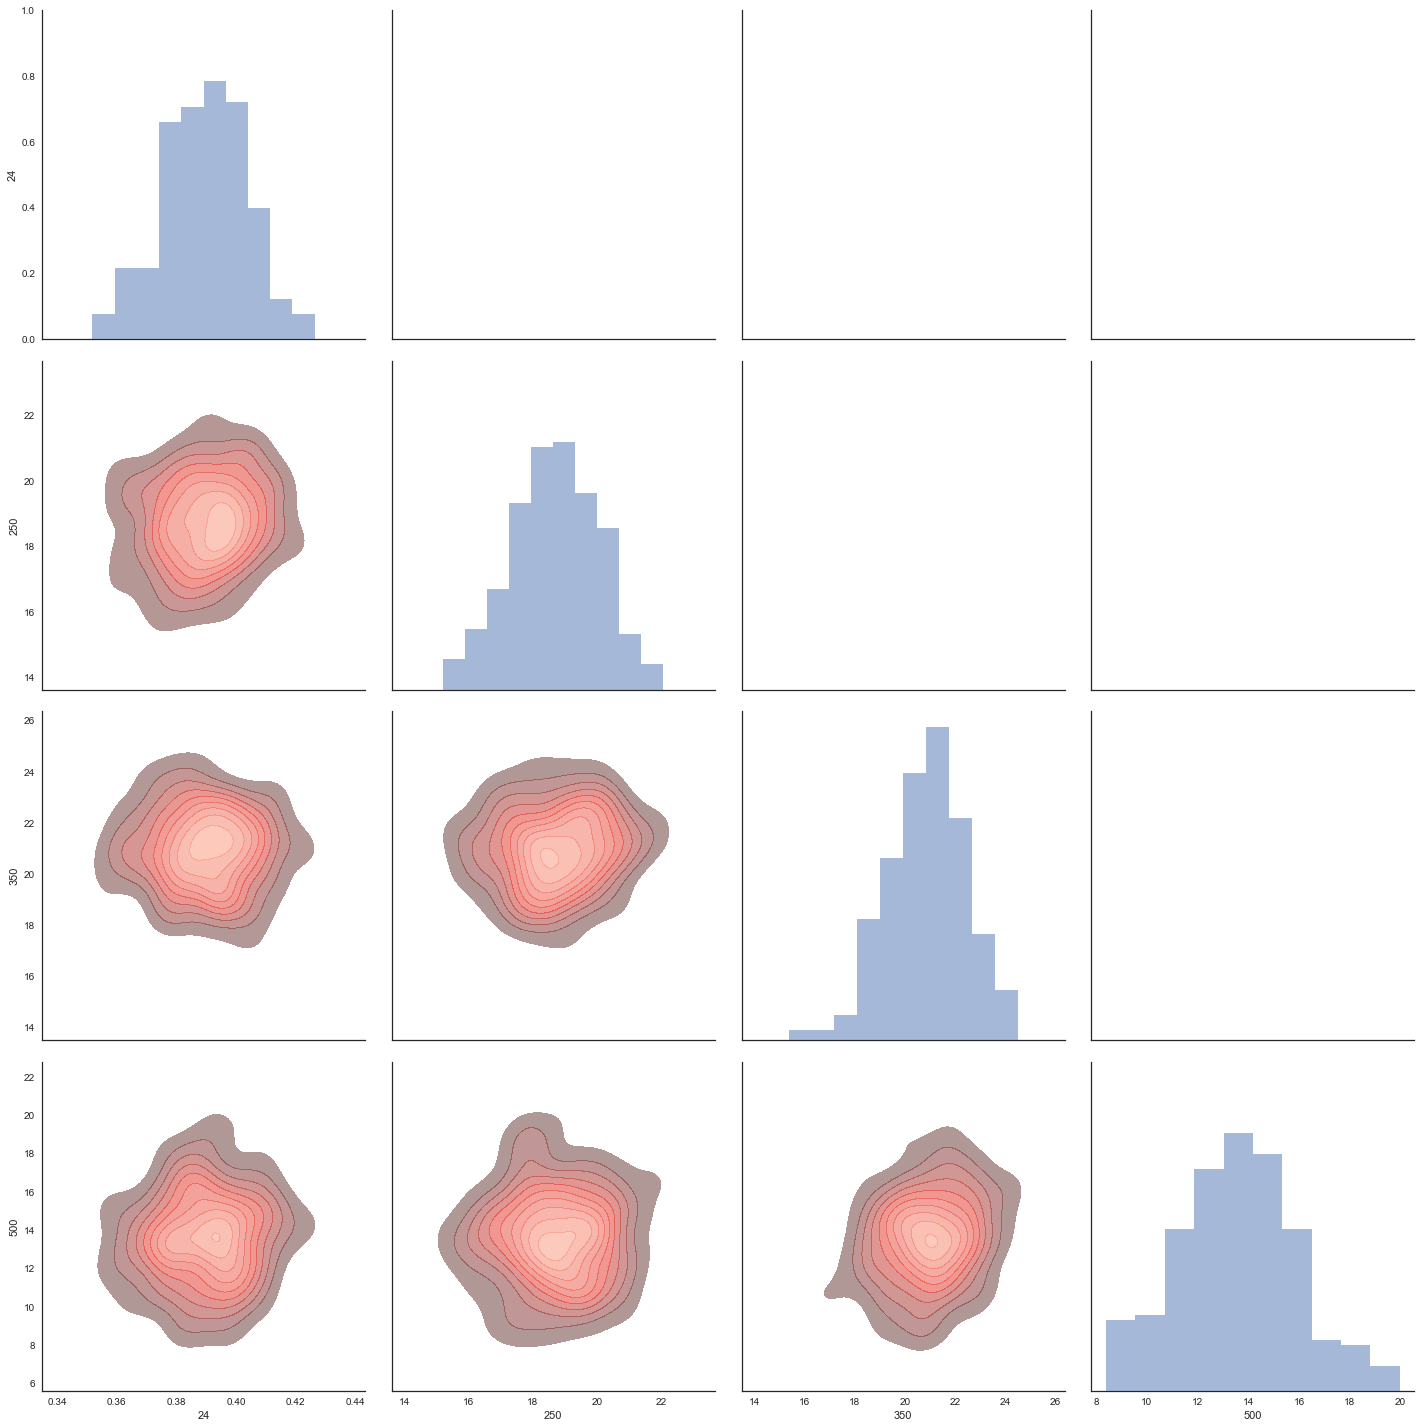

In [9]:
df = pd.DataFrame(posterior.samples['src_f'][0:259,:,s1],columns=[ '24','250', '350', '500'])
g = sns.PairGrid(df,size=5)
g.map_diag(plt.hist, alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)


## Plot Posterior SED fit, infrared Luminosity and redshift distributions
Lets plot the possible samples of SED from our fit. Each blue SED is a realisation from our posterior probability distribution. The green violin plots show the filter convolved, contrained fluxes.

Our second and third plot show the marginalised posterior probability distribution function for infra red luminosity and redshift plotted in green, with the prior plotted in red.

In [10]:
from xidplus import sed
SEDs,fullSED =sed.berta_templates(PACS=False)

[24.0, 250.0, 350.0, 500.0]


In [11]:
temps=[15,20,21,9,30,1,5,14,0]
SEDs=SEDs[temps,:,:]
t=[x+1 for x in temps]
t.insert(0,0)
fullSED=fullSED[fullSED.columns[t]]

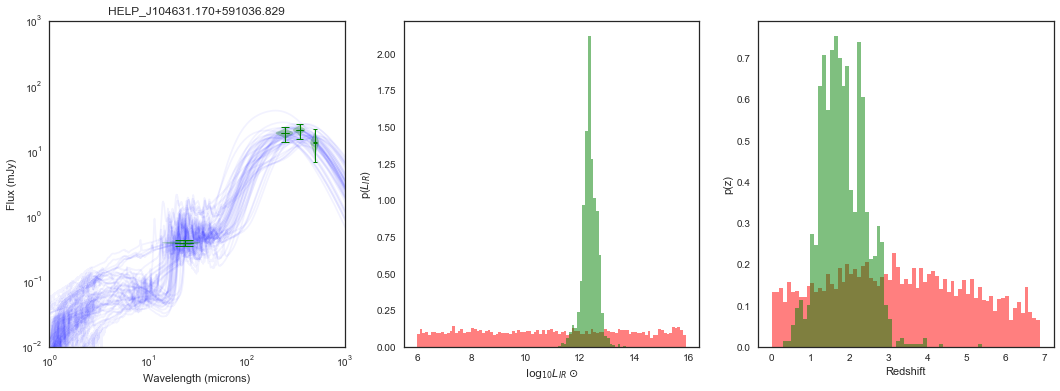

In [12]:
sns.set_style("white")

plt.figure(figsize=(18,6))
from astropy.cosmology import Planck13
plt.subplot(1,3,1)
violin_parts=plt.violinplot(posterior.samples['src_f'][:,1:4,s1],[250,350,500], points=60, widths=100,
                      showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('green')

violin_parts=plt.violinplot(posterior.samples['src_f'][:,0,s1],[24], points=60, widths=20,showmeans=True, showextrema=True, showmedians=True,bw_method=0.5)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('green')
    vp.set_linewidth(1)

for pc in violin_parts['bodies']:
    pc.set_facecolor('green')

import astropy.units as u

for s in range(0,50,1):
    z= posterior.samples['z'][s,s1]
    div=(4.0*np.pi * np.square(Planck13.luminosity_distance(z).cgs))
    div=div.value
    plt.loglog((z+1.0)*fullSED['wave'],np.power(10.0,posterior.samples['Nbb'][s,s1])*(1.0+z)*fullSED[fullSED.columns[np.arange(1,posterior.samples['p'].shape[2]+1)
                                        [np.random.multinomial(1, posterior.samples['p'][s,s1,:])==1]]]/div,alpha=0.05,c='b',zorder=0)
    
    #plt.plot([250,350,500, 24,100,160],posterior_IR.samples['src_f'][s,0:6,s1], 'ko', alpha=0.1, ms=10)
    #plt.plot([250,350,500],posterior.samples['src_f'][s,0:3,s1], 'ro', alpha=0.1, ms=10)
    


plt.ylim(1E-2,1E3)
plt.xlim(1,1000)
#plt.plot([3.6,4.5,5.7],[31.58E-3,41.72E-3,25.5E-3], 'ro')
#plt.plot([3.6,4.5,5.7,7.9],[31.58E-3,41.72E-3,25.5E-3,0.001], 'ro')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux (mJy)')
plt.title(priors[0].ID[s1])

plt.subplot(1,3,2)
plt.hist(np.random.uniform(6,16,size=5000),bins=np.arange(6,16,0.1),normed=True,color='red', alpha=0.5);
plt.hist(posterior.samples['Nbb'][:,s1], bins=np.arange(6,16,0.1),normed=True, alpha=0.5,color='green');
plt.xlabel(r'$\log_{10}L_{IR}\odot$')
plt.ylabel(r'p($L_{IR}$)')

plt.subplot(1,3,3)
plt.hist(np.random.normal(priors[0].z_median[s1],priors[0].z_sig[s1],size=5000),bins=np.arange(0,7,0.1),normed=True,color='red', alpha=0.5);
plt.hist(posterior.samples['z'][:,s1],bins=np.arange(0,7, 0.1),normed=True, alpha=0.5, color='green');
plt.xlabel('Redshift')
plt.ylabel('p(z)')

`HELP_J104631.170+591036.829` shows the SED templates are in good agreement with all the filter convolved fluxes, the infra-red luminosity is between 11-13 $\log_{10}L_{IR}\odot$ and the redshift probability distribution is rather broad (as expected when fitting with only four bands), but peaking at $\approx 1.6$. We note our prior redshift was a broad Gaussian distribution, with $\mu=3,\sigma=3$ and truncated at 0 and 7.

## Plot Table of probabilities for SED type
For each sample from our posterior, we can get a probability of it belonging to each template. We can show this as a heat map.

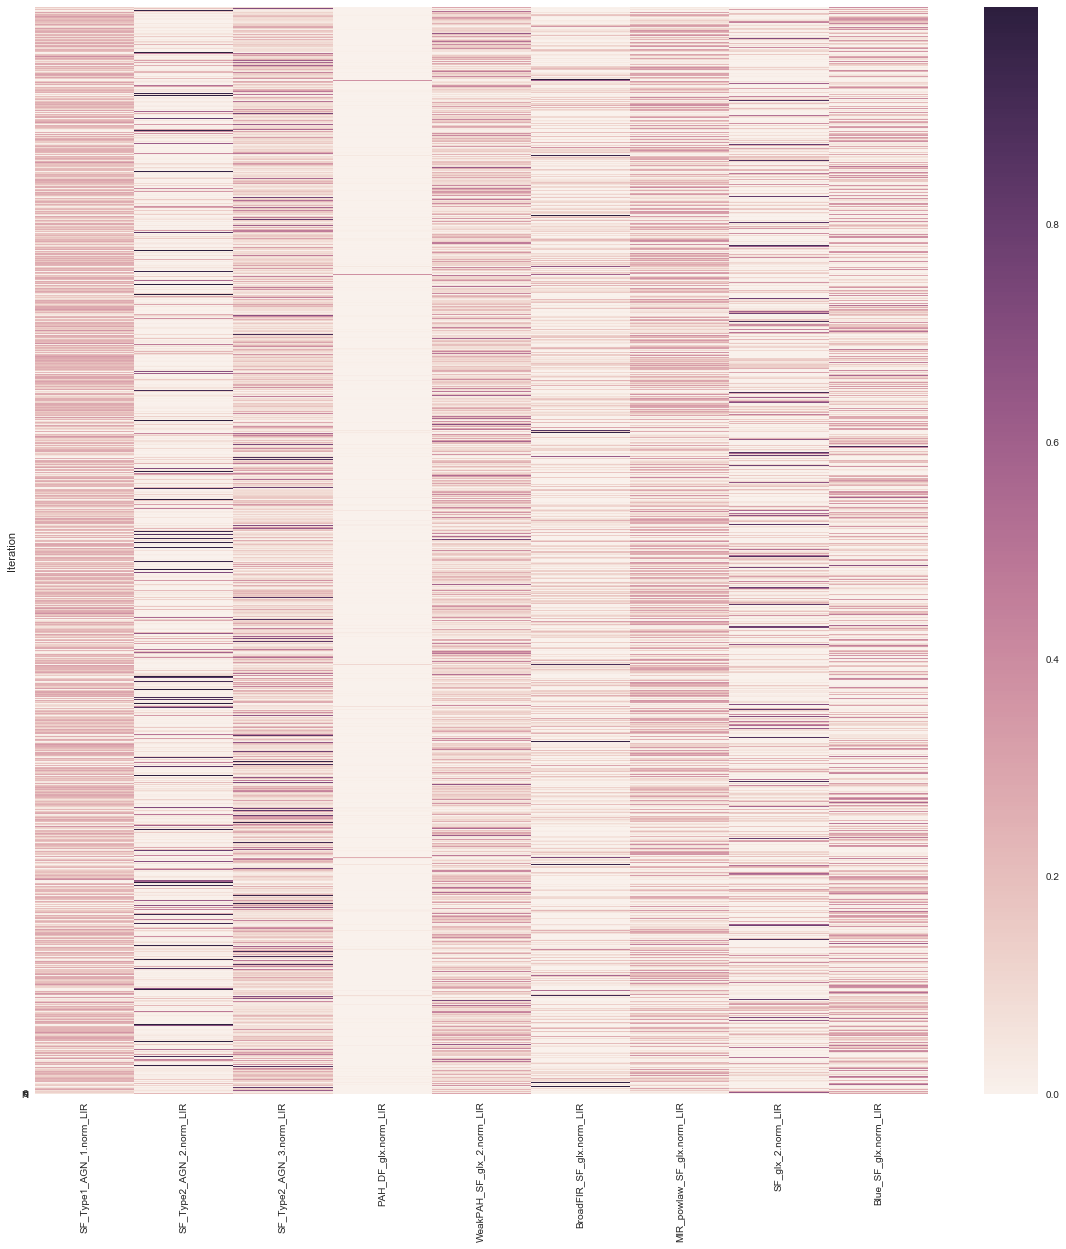

In [14]:
df=pd.DataFrame(posterior.samples['p'][:,s1,:],columns=fullSED.columns.tolist()[1:])
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df,annot=False, ax=ax)
ax.set_yticklabels('None')
ax.set_ylabel('Iteration')

## Illustrating the issue with blind source extraction

As a demonstration of how the flux is being distributed to the two sources, we can plot the posterior probability distribution function of fluxes in the marginalised 2-D colour spaces.

`HELP_J104631.082+591021.253` is shown by the red contours and `HELP_J104631.170+591036.829` in blue. To illustrate how different these fluxes are from those coming from the blind catalogues, we show an additional contour, coming from running a blind source extraction routine on our replicated maps. This provides a probability distribution function for the flux that would be measured from our model of the data. We also plot the blind source extraction carried out on the real map, shown by the black dot.

The black dot lies on top of our blind source extractions from our generated map, indicating that our model of the data is similar to the real map in regard to blind source extraction.

More importantly, the flux probability contours for `HELP_J104631.170+591036.829` are in a completely different area of colour space with regard to those coming from the blind source extraction, where as there is some overlap with `HELP_J104631.082+591021.253`. We also plot the total flux of the two sources combined are shown in orange which is much greater than that coming from blind source extraction. This plot clearly illustrates how blind source extraction routines can give miss-leading results. Not only is the flux of `HELP_J104631.170+591036.829` significantly less than that coming from blind source extraction, but that these blind source extraction can significantly underestimate the total flux coming from slightly confused SPIRE sources.

In [17]:

from xidplus import posterior_maps as postmaps
mod_map_array=postmaps.replicated_maps(priors,posterior,nrep=1500)


In [18]:
from photutils import DAOStarFinder
fwhm=[2,17.6,23.9,35.2]
tmp_fits=postmaps.make_fits_image(priors[1],priors[1].sim)
daofind = DAOStarFinder(fwhm=fwhm[1]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=1)    
s250 = daofind(tmp_fits[1].data)
print(s250)
tmp_fits=postmaps.make_fits_image(priors[2],priors[2].sim)
daofind = DAOStarFinder(fwhm=fwhm[2]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=1)    
s350 = daofind(tmp_fits[1].data)
print(s350)
tmp_fits=postmaps.make_fits_image(priors[3],priors[3].sim)
daofind = DAOStarFinder(fwhm=fwhm[3]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=1)    
s500 = daofind(tmp_fits[1].data)
print(s500)

 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 10.2634527358  9.1052840759 ... 20.3806514462 12.2704697227  -2.7221529704
  2  2.1477260587 11.1407367685 ... 13.5036637849 12.9632433577 -2.78178418519
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 6.71985314541 6.00091138137 ... 32.6322400828 21.6579123458 -3.33904147924
  2 9.69966280309 10.1035861653 ... 15.1458101613 13.2797976702 -2.80797864553
 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  1 4.13421059073 4.22668532022 ... 27.0488362808 21.8108916631 -3.34668355143


In [19]:
s250=s250[0]
s350=s350[0]
s500=s500[0]
actual_source=[None,s250,s350,s500]

In [20]:
starfinder_fluxes=np.empty_like(posterior.samples['src_f'][:,:,0])
starfinder_fluxes[:,:]=-5
fwhm=[2,17.6,23.9,35.2]
for b in range(1,len(priors)):
    ii=0
    for s in range(0,posterior.samples['src_f'].shape[0]):
        tmp_fits=postmaps.make_fits_image(priors[b],mod_map_array[b][:,s])
        daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=1) 
        sources = daofind(tmp_fits[1].data)   
        try:
            ind=np.argmin(np.sqrt((sources['xcentroid']-actual_source[b]['xcentroid'])**2+(sources['ycentroid']-actual_source[b]['ycentroid'])**2))
            starfinder_fluxes[s,b]=sources['peak'][ind]
        except ValueError:
            #print(b,s,ii)
            ii+=1
starfinder_fluxes[:,0]=posterior.samples['src_f'][:,0,68]-5


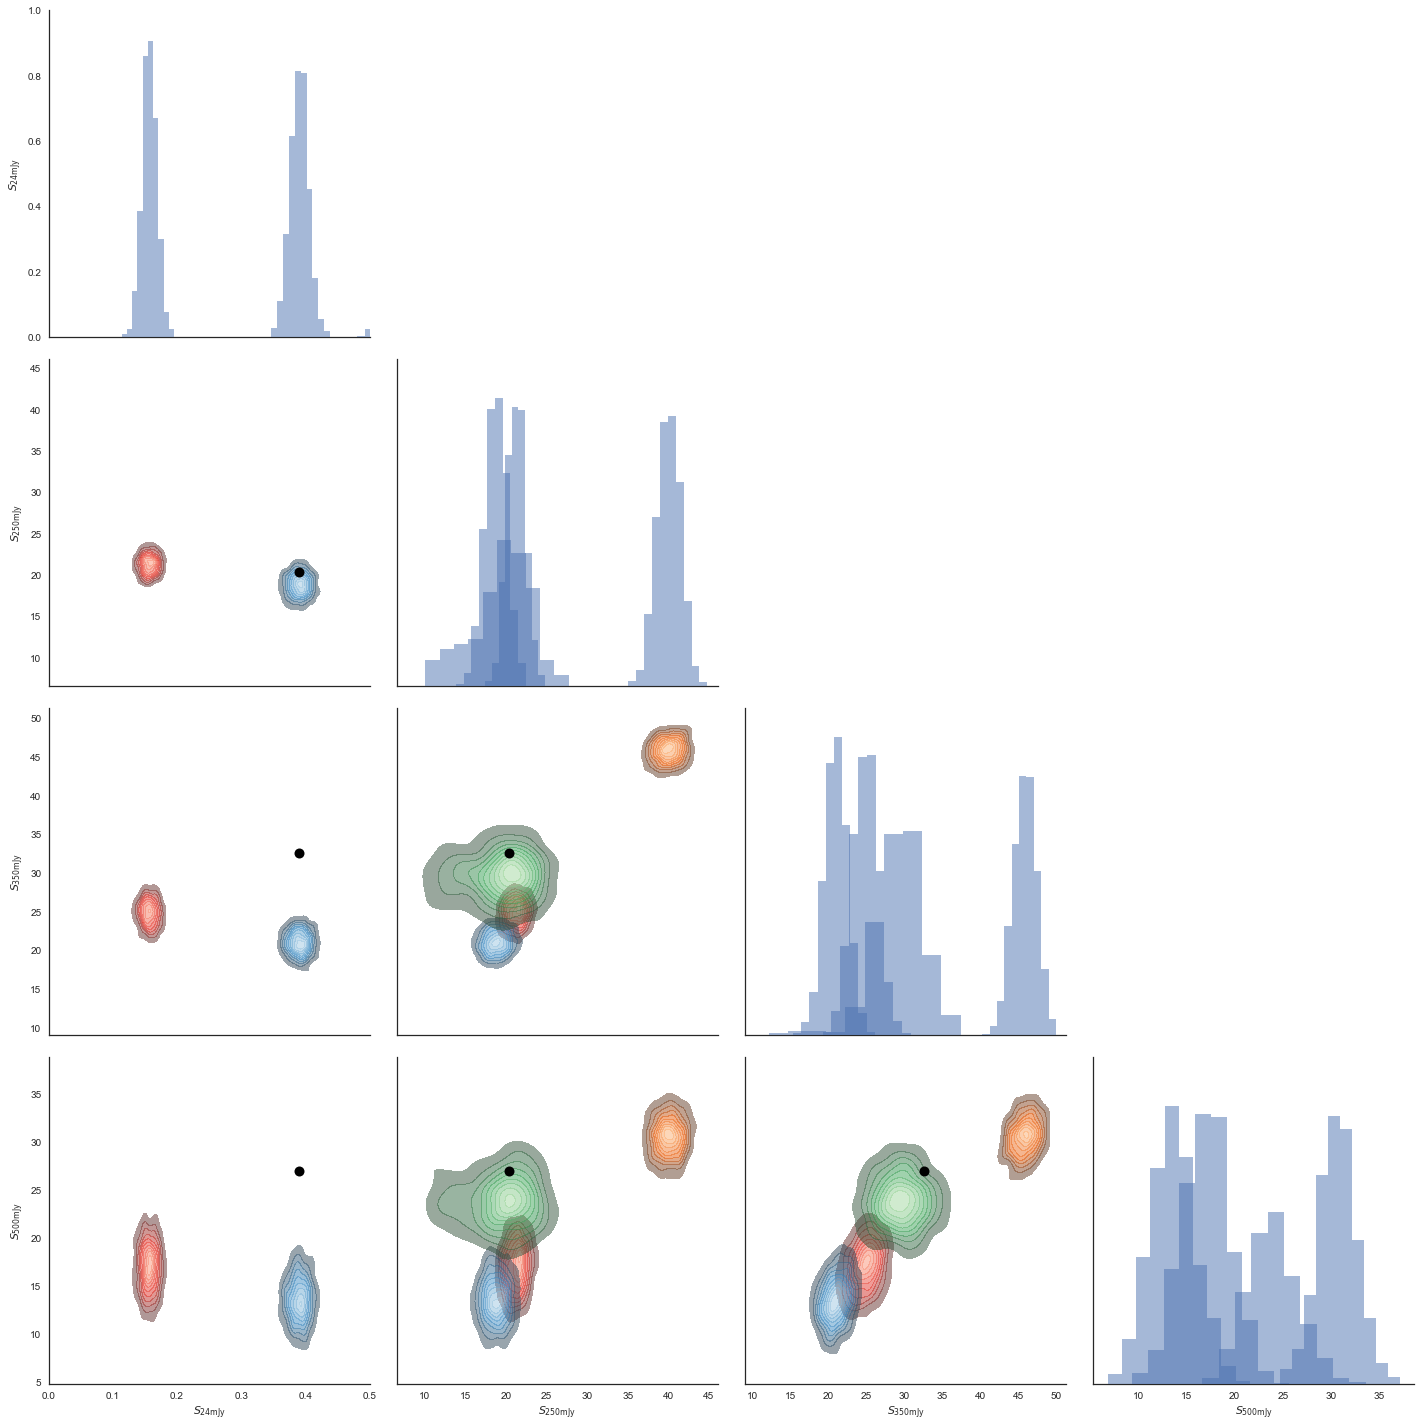

In [21]:
s1=73
s2=68
s3=99
sns.set_style("white")

df = pd.DataFrame(posterior.samples['src_f'][:,:,s1],columns=[ '$S_{24\mathrm{mJy}}$','$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g = sns.PairGrid(df,size=5)
g.map_diag(plt.hist, alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Reds_d",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)

df = pd.DataFrame(posterior.samples['src_f'][:,:,s2],columns=[ '$S_{24\mathrm{mJy}}$','$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df
g.map_diag(plt.hist, alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Blues_d",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)


df = pd.DataFrame(posterior.samples['src_f'][:,:,s1]+posterior.samples['src_f'][:,:,s2],columns=[ '$S_{24\mathrm{mJy}}$','$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df
g.map_diag(plt.hist, alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Oranges_d",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)

df = pd.DataFrame(starfinder_fluxes[(starfinder_fluxes[:,3]>10) & (starfinder_fluxes[:,2]>10) & (starfinder_fluxes[:,1]>10),:],columns=[ '$S_{24\mathrm{mJy}}$','$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df
g.map_diag(plt.hist, alpha=0.5)
g.map_lower(sns.kdeplot, cmap="Greens_d",alpha=0.5,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.axes[1,0].plot(0.39,20.38,'ko',ms=10)
g.axes[2,0].plot(0.39,32.63,'ko',ms=10)
g.axes[3,0].plot(0.39,27.0,'ko',ms=10)

g.axes[2,1].plot(20.38,32.63,'ko',ms=10)
g.axes[3,1].plot(20.38,27.0,'ko',ms=10)

g.axes[3,2].plot(32.63,27.0,'ko',ms=10)
g.axes[0,1].set_axis_off()
g.axes[0,2].set_axis_off()
g.axes[0,3].set_axis_off()
g.axes[1,2].set_axis_off()
g.axes[1,3].set_axis_off()
g.axes[2,3].set_axis_off()

for i in (g.axes[:,0]):
    i.set_xlim(0,0.5)